# Learning to Reweight Examples for Robust Deep Learning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/ML_Project

/content/drive/.shortcut-targets-by-id/1WNR3o2CO38kvudaWBLsGkvJvMa4hkl39/ML_Project


In [ ]:

#!git clone https://github.com/danieltan07/learning-to-reweight-examples.git

In [ ]:
%cd /content/drive/MyDrive/ML_Project/learning-to-reweight-examples/

/content/drive/.shortcut-targets-by-id/1WNR3o2CO38kvudaWBLsGkvJvMa4hkl39/ML_Project/learning-to-reweight-examples


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from model import *
from data_loader import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import IPython
import gc
import matplotlib
matplotlib.rcParams.update({'errorbar.capsize': 5})

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
hyperparameters = {
    'lr' : 1e-3,
    'momentum' : 0.9,
    'batch_size' : 100,
    'num_iterations' : 8000,
}

### Dataset
Following the class imbalance experiment in the paper, we used numbers 9 and 4 of the MNIST dataset to form a highly imbalanced dataset where 9 is the dominating class. The test set on the other hand is balanced.

In [ ]:
data_loader = get_mnist_loader(hyperparameters['batch_size'], classes=[9, 4], proportion=0.995, mode="train")
test_loader = get_mnist_loader(hyperparameters['batch_size'], classes=[9, 4], proportion=0.5, mode="test")

/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [ ]:
def to_var(x, requires_grad=True):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, requires_grad=requires_grad)



```
# This is formatted as code
```

#### Since the validation data is small (only 10 examples) there is no need to wrap it in a dataloader

In [ ]:
val_data = to_var(data_loader.dataset.data_val, requires_grad=False)
val_labels = to_var(data_loader.dataset.labels_val, requires_grad=False)

print one batch of data to see if the train data is really imbalanced and if the test data is balanced.

In [ ]:
for i,(img, label) in enumerate(data_loader):
    print(img.size(),label)
    break

torch.Size([100, 1, 32, 32]) tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


In [ ]:
for i,(img, label) in enumerate(test_loader):
    print(img.size(),label)
    break

torch.Size([100, 1, 32, 32]) tensor([1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1.,
        1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1.,
        0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1.,
        1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 0., 0., 1., 1., 1., 0., 1., 1., 1.])


In [ ]:
def build_model():
    net = LeNet(n_out=1)

    if torch.cuda.is_available():
        net.cuda()
        torch.backends.cudnn.benchmark=True

    opt = torch.optim.SGD(net.params(),lr=hyperparameters["lr"])
    
    return net, opt

## Baseline Model
I trained a LeNet model for the MNIST data without weighting the loss as a baseline model for comparison.

In [ ]:
net, opt = build_model()

net_losses = []
plot_step = 100
net_l = 0

smoothing_alpha = 0.9
accuracy_log = []
for i in tqdm(range(hyperparameters['num_iterations'])):
    net.train()
    image, labels = next(iter(data_loader))

    image = to_var(image, requires_grad=False)
    labels = to_var(labels, requires_grad=False)

    y = net(image)
    cost = F.binary_cross_entropy_with_logits(y, labels)
    
    opt.zero_grad()
    cost.backward()
    opt.step()
    
    net_l = smoothing_alpha *net_l + (1 - smoothing_alpha)* cost.item()
    net_losses.append(net_l/(1 - smoothing_alpha**(i+1)))
    
    if i % plot_step == 0:
        net.eval()
        
        acc = []
        for itr,(test_img, test_label) in enumerate(test_loader):
            test_img = to_var(test_img, requires_grad=False)
            test_label = to_var(test_label, requires_grad=False)
            
            output = net(test_img)
            predicted = (F.sigmoid(output) > 0.5).int()
            
            acc.append((predicted.int() == test_label.int()).float())

        accuracy = torch.cat(acc,dim=0).mean()
        accuracy_log.append(np.array([i,accuracy])[None])
        
        
        IPython.display.clear_output()
        fig, axes = plt.subplots(1, 2, figsize=(13,5))
        ax1, ax2 = axes.ravel()

        ax1.plot(net_losses, label='net_losses')
        ax1.set_ylabel("Losses")
        ax1.set_xlabel("Iteration")
        ax1.legend()
        
        acc_log = np.concatenate(accuracy_log, axis=0)
        ax2.plot(acc_log[:,0],acc_log[:,1])
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Iteration')
        plt.show()

<class 'model.LeNet'>


As expected, due to the heavily imbalanced training data, the network could not learn how to differentiate between 9 and 4.

## Learning to Reweight Examples 
Below is a pseudocode of the method proposed in the paper. It is very straightforward.

<img src="pseudocode.PNG" width="300" />



In [ ]:
def train_lre():
    net, opt = build_model()
    
    meta_losses_clean = []
    net_losses = []
    plot_step = 100

    smoothing_alpha = 0.9
    
    meta_l = 0
    net_l = 0
    accuracy_log = []
    for i in tqdm(range(hyperparameters['num_iterations'])):
        net.train()
        # Line 2 get batch of data
        image, labels = next(iter(data_loader))
        # since validation data is small I just fixed them instead of building an iterator
        # initialize a dummy network for the meta learning of the weights
        meta_net = LeNet(n_out=1)
        meta_net.load_state_dict(net.state_dict())

        if torch.cuda.is_available():
            meta_net.cuda()

        image = to_var(image, requires_grad=False)
        labels = to_var(labels, requires_grad=False)

        # Lines 4 - 5 initial forward pass to compute the initial weighted loss
        y_f_hat  = meta_net(image)
        cost = F.binary_cross_entropy_with_logits(y_f_hat,labels, reduce=False)
        eps = to_var(torch.zeros(cost.size()))
        l_f_meta = torch.sum(cost * eps)

        meta_net.zero_grad()
        
        # Line 6 perform a parameter update
        grads = torch.autograd.grad(l_f_meta, (meta_net.params()), create_graph=True)
        meta_net.update_params(hyperparameters['lr'], source_params=grads)
        
        # Line 8 - 10 2nd forward pass and getting the gradients with respect to epsilon
        y_g_hat = meta_net(val_data)

        l_g_meta = F.binary_cross_entropy_with_logits(y_g_hat,val_labels)

        grad_eps = torch.autograd.grad(l_g_meta, eps, only_inputs=True)[0]
        
        # Line 11 computing and normalizing the weights
        w_tilde = torch.clamp(-grad_eps,min=0)
        norm_c = torch.sum(w_tilde)

        if norm_c != 0:
            w = w_tilde / norm_c
        else:
            w = w_tilde

        # Lines 12 - 14 computing for the loss with the computed weights
        # and then perform a parameter update
        y_f_hat = net(image)
        cost = F.binary_cross_entropy_with_logits(y_f_hat, labels, reduce=False)
        l_f = torch.sum(cost * w)

        opt.zero_grad()
        l_f.backward()
        opt.step()

        meta_l = smoothing_alpha *meta_l + (1 - smoothing_alpha)* l_g_meta.item()
        meta_losses_clean.append(meta_l/(1 - smoothing_alpha**(i+1)))

        net_l = smoothing_alpha *net_l + (1 - smoothing_alpha)* l_f.item()
        net_losses.append(net_l/(1 - smoothing_alpha**(i+1)))

        if i % plot_step == 0:
            net.eval()

            acc = []
            for itr,(test_img, test_label) in enumerate(test_loader):
                test_img = to_var(test_img, requires_grad=False)
                test_label = to_var(test_label, requires_grad=False)

                output = net(test_img)
                predicted = (F.sigmoid(output) > 0.5).int()
                print(predicted.size())
                acc.append((predicted.int() == test_label.int()).float())
                print(acc.size())
            accuracy = torch.cat(acc,dim=0).mean()
            accuracy_log.append(np.array([i,accuracy])[None])


            IPython.display.clear_output()
            fig, axes = plt.subplots(1, 2, figsize=(13,5))
            ax1, ax2 = axes.ravel()

            ax1.plot(meta_losses_clean, label='meta_losses_clean')
            ax1.plot(net_losses, label='net_losses')
            ax1.set_ylabel("Losses")
            ax1.set_xlabel("Iteration")
            ax1.legend()

            acc_log = np.concatenate(accuracy_log, axis=0)
            ax2.plot(acc_log[:,0],acc_log[:,1])
            ax2.set_ylabel('Accuracy')
            ax2.set_xlabel('Iteration')
            plt.show()
            
        # return accuracy
    return np.mean(acc_log[-6:-1, 1])

**To** get an idea of how robust this method is with respect to the 

proportion of the dominant class, I varied the proportion from 0.9 to 0.995 and perform 5 runs for each. 

In [ ]:
num_repeats = 5
proportions = [0.9,0.95, 0.98, 0.99, 0.995]
accuracy_log = {}

for prop in proportions:
    data_loader = get_mnist_loader(hyperparameters['batch_size'], classes=[9, 4], proportion=prop, mode="train")
    val_data = to_var(data_loader.dataset.data_val, requires_grad=False)
    val_labels = to_var(data_loader.dataset.labels_val, requires_grad=False)
    
    for k in range(num_repeats):
        accuracy = train_lre()
        
        if prop in accuracy_log:
            accuracy_log[prop].append(accuracy)
        else:
            accuracy_log[prop] = [accuracy]

plt.figure(figsize=(10,8))
for prop in proportions:
    accuracies = accuracy_log[prop]
    plt.scatter([prop] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(accuracy_log.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(accuracy_log.items())])
plt.errorbar(proportions, accuracies_mean, yerr=accuracies_std)
plt.title('Performance on varying class proportions')
plt.xlabel('proportions')
plt.ylabel('Accuracy')
plt.show()

NameError: ignored

We can see that even at 0.995 proportion of the dominant class in the training data, the model still reaches 90+% accuracy on the balanced test data.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from model import *
from data_loader import *
from wide_resnet import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import IPython
import gc
import matplotlib
matplotlib.rcParams.update({'errorbar.capsize': 5})
import numpy as np
import random
import os
import csv

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
hyperparameters = {
    'lr' : 0.1,
    'momentum' : 0.9,
    'batch_size' : 25,
    'num_iterations' : 100,
}

In [ ]:
data_loader = get_cifar_loader(hyperparameters['batch_size'], cifar_type="10", mode="train", run_type="unif_flip")
test_loader = get_cifar_loader(hyperparameters['batch_size'], cifar_type="10", mode="test",run_type="unif_flip")

Files already downloaded and verified
50000
unif_flip
torch.Size([1000, 3, 32, 32])
torch.Size([1000])


/content/drive/.shortcut-targets-by-id/1WNR3o2CO38kvudaWBLsGkvJvMa4hkl39/ML_Project/learning-to-reweight-examples/data_loader.py:176: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  self.data = torch.tensor(self.data).squeeze(0)


Files already downloaded and verified


In [ ]:
def to_var(x, requires_grad=True):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, requires_grad=requires_grad)

In [ ]:
def build_model_wrn(cifar_type, model_type):
    net = Wide_ResNet(28, 10, 0.3, cifar_type)
    if(model_type == "baseline"):
      if os.path.isfile("cifar_unif_baseline.pt"):
        net.load_state_dict(torch.load('cifar_unif_baseline.pt'))
    elif(model_type == "reweight"):
      if os.path.isfile("cifar_unif_reweight.pt"):
        net.load_state_dict(torch.load('cifar_unif_reweight.pt'))
    if torch.cuda.is_available():
        net.cuda()
        torch.backends.cudnn.benchmark=True

    opt = torch.optim.SGD(net.params(),lr=hyperparameters["lr"])
    
    return net, opt

In [ ]:
val_data = data_loader.dataset.data_val
val_labels = data_loader.dataset.labels_val

#val_data = val_data[:100]
#val_labels = val_labels[:100]

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

val_dataset = CIFAR_VAL(val_data, val_labels)
val_data_loader = DataLoader(dataset=val_dataset,
                             batch_size=25,
                             shuffle=True, num_workers=2)
    

In [ ]:
iter_start = 0
iter_end = 0

In [ ]:
from wide_resnet import Wide_ResNet

def train_lre_cifar_baseline():
    net_baseline, opt_baseline = build_model_wrn(cifar_type=10,model_type="baseline")

    global val_data
    global val_labels
    net_losses_baseline = []
    plot_step = 100
    smoothing_alpha = 0.9
    accuracy_log_baseline = []
    lr_update = 1

    csv_net_losses_baseline = []
    csv_acc_baseline = []
    if os.path.isfile("acc_log_baseline_cifar_unif_flip.csv"):
      with open("acc_log_baseline_cifar_unif_flip.csv", "r") as csv_file:
        reader = csv.reader(csv_file, delimiter=',')
        for row in reader:
          csv_acc_baseline.append(list(np.float_(row)))
      csv_file.close()
      with open("loss_log_baseline_cifar_unif_flip.csv", "r") as csv_file:
        reader = csv.reader(csv_file, delimiter=',')
        for row in reader:
          csv_net_losses_baseline.append(list(np.float_(row)))
      csv_file.close()

    csv_net_losses_baseline = np.array(csv_net_losses_baseline)
    csv_acc_baseline = np.array(csv_acc_baseline)

    for i in tqdm(range(iter_start,iter_end)):
        if i > 40000:
          lr_update = 0.1
        if i > 50000:
          lr_update = 0.01
        opt_baseline.param_groups[0]['lr'] = lr_update * hyperparameters['lr']
        net_baseline.train()
        # Line 2 get batch of data
        image, labels = next(iter(data_loader))
        image = to_var(image, requires_grad=False)
        labels = to_var(labels.type(torch.LongTensor), requires_grad=False)   
        y_baseline = net_baseline(image)
        cost_baseline = F.cross_entropy(y_baseline, labels)

        opt_baseline.zero_grad()
        cost_baseline.backward()
        opt_baseline.step()

        net_losses_baseline.append(cost_baseline.item())

        if i % plot_step == 0:
            net_baseline.eval()
            acc_baseline = []
            for itr,(test_img, test_label) in enumerate(test_loader):
                test_img = to_var(test_img, requires_grad=False)
                test_label = to_var(test_label, requires_grad=False)

                output_baseline = net_baseline(test_img)
                output_baseline = F.softmax(output_baseline, dim = 1)
                predicted_baseline = torch.argmax(output_baseline, dim = 1).int()
                acc_baseline.append((predicted_baseline.int() == test_label.int()).float())
            accuracy_baseline = torch.cat(acc_baseline,dim=0).mean()
            accuracy_log_baseline.append(np.array([i,accuracy_baseline.cpu()])[None])

            IPython.display.clear_output()
            fig, axes = plt.subplots(1, 2, figsize=(13,5))
            ax1, ax2 = axes.ravel()

            net_losses_baseline_plot = np.concatenate((csv_net_losses_baseline.flatten(),np.array(net_losses_baseline)), axis=0) if csv_net_losses_baseline.size else np.array(net_losses_baseline)
            ax1.plot(net_losses_baseline_plot, label='net_losses_baseline')
            ax1.set_ylabel("Losses")
            ax1.set_xlabel("Iteration")
            ax1.legend()

            acc_log_baseline = np.concatenate((csv_acc_baseline, np.concatenate(accuracy_log_baseline,axis=0)), axis=0) if csv_acc_baseline.size else np.concatenate(accuracy_log_baseline,axis=0)
            ax2.plot(acc_log_baseline[:,0],100*acc_log_baseline[:,1],label='accuracy_baseline')
            ax2.legend()
            ax2.set_ylabel('Accuracy %')
            ax2.set_xlabel('Iteration')
            plt.show()

    torch.save(net_baseline.state_dict(), 'cifar_unif_baseline.pt')
        # return accuracy
    return np.mean(acc_log_baseline[-6:-1, 1]), np.concatenate(accuracy_log_baseline,axis=0), np.array(net_losses_baseline) 

In [ ]:
iter_start = 1000
iter_end = 10000

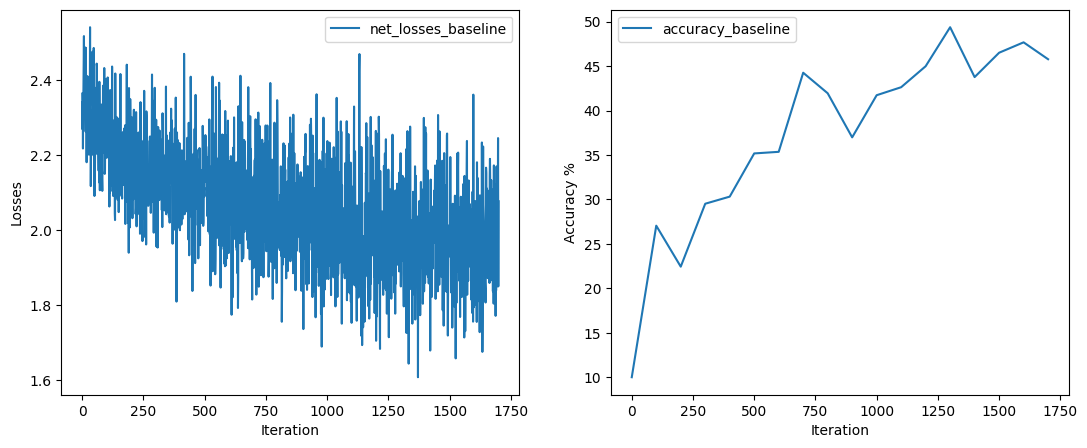

  9%|▊         | 767/9000 [09:26<1:41:20,  1.35it/s]


KeyboardInterrupt: ignored

In [ ]:
_ , acc_log_baseline, net_losses_baseline = train_lre_cifar_baseline()
with open('acc_log_baseline_cifar_unif_flip.csv','a') as csvfile:
  np.savetxt(csvfile, acc_log_baseline, delimiter=',',fmt='%s', comments='')
  csvfile.close()
with open('loss_log_baseline_cifar_unif_flip.csv','a') as csvfile:
  np.savetxt(csvfile, net_losses_baseline, delimiter=',',fmt='%s', comments='')
  csvfile.close()

In [ ]:
from wide_resnet import Wide_ResNet

def train_lre_cifar_reweight():
    net, opt = build_model_wrn(cifar_type=10,model_type="reweight")
    global val_data
    global val_labels
    net_losses = []
    plot_step = 100

    smoothing_alpha = 0.9
    accuracy_log = []    
    lr_update = 1
    csv_net_losses = []
    csv_acc = []
    if os.path.isfile("acc_log_cifar_unif_flip.csv"):
      with open("acc_log_cifar_unif_flip.csv", "r") as csv_file:
        reader = csv.reader(csv_file, delimiter=',')
        for row in reader:
          csv_acc.append(list(np.float_(row)))
      csv_file.close()
      with open("loss_log_cifar_unif_flip.csv", "r") as csv_file:
        reader = csv.reader(csv_file, delimiter=',')
        for row in reader:
          csv_net_losses.append(list(np.float_(row)))
      csv_file.close()

    csv_net_losses = np.array(csv_net_losses)
    csv_acc = np.array(csv_acc)

    for i in tqdm(range(iter_start,iter_end)):
        if i > 40000:
          lr_update = 0.1
        if i > 50000:
          lr_update = 0.01
        opt.param_groups[0]['lr'] = lr_update * hyperparameters['lr']
        net.train()
        # Line 2 get batch of data
        image, labels = next(iter(data_loader))
        # since validation data is small I just fixed them instead of building an iterator
        # initialize a dummy network for the meta learning of the weights
        meta_net = Wide_ResNet(28, 10, 0.3, 10)
        meta_net.load_state_dict(net.state_dict())

        if torch.cuda.is_available():
            meta_net.cuda()

        image = to_var(image, requires_grad=False)
        labels = to_var(labels.type(torch.LongTensor), requires_grad=False)

        # Lines 4 - 5 initial forward pass to compute the initial weighted loss
        y_f_hat  = meta_net(image)
        cost = F.cross_entropy(y_f_hat,labels.type(torch.LongTensor).cuda(), reduce=False)
        eps = to_var(torch.zeros(cost.size()))
        l_f_meta = torch.sum(cost * eps)

        meta_net.zero_grad()
        
        # Line 6 perform a parameter update
        grads = torch.autograd.grad(l_f_meta, (meta_net.params()), create_graph=True)
        meta_net.update_params(lr_update*hyperparameters['lr'], source_params=grads)
        
        #select 200 images from the proposed 1000 validation images in the paper
        w_tilde_all = []
        for j in range(0,20):
          #print(j)
          image_val, labels_val = next(iter(val_data_loader))
          val_data_train = to_var(image_val, requires_grad=False)
          val_labels_train = to_var(labels_val, requires_grad=False)
          y_g_hat = meta_net(val_data_train)
          l_g_meta = F.cross_entropy(y_g_hat, val_labels_train)
          grad_eps = torch.autograd.grad(l_g_meta, eps, only_inputs=True, retain_graph=True)[0]

          # Line 11 computing and normalizing the weights
        
          w_tilde = torch.clamp(-grad_eps, min=0)
          #print(w_tilde.shape)
          w_tilde_all.append(w_tilde)

       # print(len(w_tilde_all))
        w_tilde_all = torch.vstack(w_tilde_all)
        #print(w_tilde_all.shape)
        w_tilde_mean = torch.mean(w_tilde_all, dim = 0)
        #print(w_tilde_mean.shape)
        norm_c = torch.sum(w_tilde_mean)

        if norm_c != 0:
            w = w_tilde_mean / norm_c
        else:
            w = w_tilde_mean

        # Lines 12 - 14 computing for the loss with the computed weights
        # and then perform a parameter update
        y_f_hat = net(image)
        cost = F.cross_entropy(y_f_hat, labels, reduce=False)
        l_f = torch.sum(cost * w)

        opt.zero_grad()
        l_f.backward()
        opt.step()

        net_losses.append(l_f.item())

        if i % plot_step == 0:
            net.eval()
            acc = []
            for itr,(test_img, test_label) in enumerate(test_loader):
                test_img = to_var(test_img, requires_grad=False)
                test_label = to_var(test_label, requires_grad=False)

                output = net(test_img)
                output = F.softmax(output, dim = 1)
                predicted = torch.argmax(output, dim = 1).int()
                acc.append((predicted.int() == test_label.int()).float())
            accuracy = torch.cat(acc,dim=0).mean()
            accuracy_log.append(np.array([i,accuracy.cpu()])[None])

            IPython.display.clear_output()
            fig, axes = plt.subplots(1, 2, figsize=(13,5))
            ax1, ax2 = axes.ravel()

            net_losses_plot = np.concatenate((csv_net_losses.flatten(),np.array(net_losses)), axis=0) if csv_net_losses.size else np.array(net_losses)
            ax1.plot(net_losses_plot, label='net_losses_reweighted')
            ax1.set_ylabel("Losses")
            ax1.set_xlabel("Iteration")
            ax1.legend()

            acc_log = np.concatenate((csv_acc,np.concatenate(accuracy_log,axis=0)), axis=0) if csv_acc.size else np.concatenate(accuracy_log,axis=0)
            ax2.plot(acc_log[:,0],100*acc_log[:,1],label='accuracy_reweighted')
            ax2.legend()
            ax2.set_ylabel('Accuracy %')
            ax2.set_xlabel('Iteration')
            plt.show()

    torch.save(net.state_dict(), 'cifar_unif_reweight.pt')        
        # return accuracy
    return np.mean(acc_log[-6:-1, 1]), np.concatenate(accuracy_log,axis=0), np.array(net_losses) 

In [ ]:
iter_start = 0
iter_end = 1000

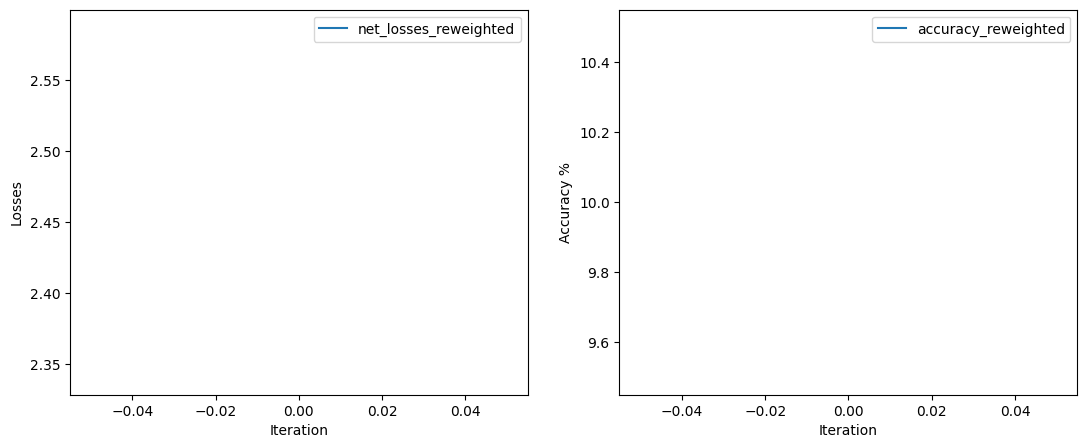

  0%|          | 1/1000 [00:39<11:01:17, 39.72s/it]

| Wide-Resnet 28x10


  0%|          | 2/1000 [01:00<7:57:53, 28.73s/it] 

| Wide-Resnet 28x10


  0%|          | 3/1000 [01:20<6:49:57, 24.67s/it]

| Wide-Resnet 28x10


  0%|          | 4/1000 [01:40<6:21:12, 22.96s/it]

| Wide-Resnet 28x10


  0%|          | 5/1000 [02:00<6:01:37, 21.81s/it]

| Wide-Resnet 28x10


  1%|          | 6/1000 [02:20<5:51:21, 21.21s/it]

| Wide-Resnet 28x10


  1%|          | 7/1000 [02:41<5:46:39, 20.95s/it]

| Wide-Resnet 28x10


In [ ]:
_ , acc_log, net_losses = train_lre_cifar_reweight()
with open('acc_log_cifar_unif_flip.csv','a') as csvfile:
  np.savetxt(csvfile, acc_log, delimiter=',',fmt='%s', comments='')
  csvfile.close()
with open('loss_log_cifar_unif_flip.csv','a') as csvfile:
  np.savetxt(csvfile, net_losses, delimiter=',',fmt='%s', comments='')
  csvfile.close()

In [ ]:
from wide_resnet import Wide_ResNet

def train_lre_cifar():
    net, opt = build_model_wrn(cifar_type=10,model_type="reweight")
    net_baseline, opt_baseline = build_model_wrn(cifar_type=10,model_type="baseline")

    global val_data
    global val_labels
    net_losses = []
    net_losses_baseline = []
    plot_step = 10

    smoothing_alpha = 0.9
    
    meta_l = 0
    accuracy_log = []
    accuracy_log_baseline = []
    
    lr_update = 1

    csv_net_losses = []
    csv_net_losses_baseline = []
    csv_acc = []
    csv_acc_baseline = []
    if os.path.isfile("acc_log_cifar_unif_flip.csv"):
      with open("acc_log_cifar_unif_flip.csv", "r") as csv_file:
        reader = csv.reader(csv_file, delimiter=',')
        for row in reader:
          csv_acc.append(list(np.float_(row)))
      csv_file.close()
      with open("acc_log_baseline_cifar_unif_flip.csv", "r") as csv_file:
        reader = csv.reader(csv_file, delimiter=',')
        for row in reader:
          csv_acc_baseline.append(list(np.float_(row)))
      csv_file.close()
      with open("loss_log_cifar_unif_flip.csv", "r") as csv_file:
        reader = csv.reader(csv_file, delimiter=',')
        for row in reader:
          csv_net_losses.append(list(np.float_(row)))
      csv_file.close()
      with open("loss_log_baseline_cifar_unif_flip.csv", "r") as csv_file:
        reader = csv.reader(csv_file, delimiter=',')
        for row in reader:
          csv_net_losses_baseline.append(list(np.float_(row)))
      csv_file.close()

    csv_net_losses = np.array(csv_net_losses)
    csv_net_losses_baseline = np.array(csv_net_losses_baseline)
    csv_acc = np.array(csv_acc)
    csv_acc_baseline = np.array(csv_acc_baseline)

    for i in tqdm(range(iter_start,iter_end)):
        if i > 40000:
          lr_update = 0.1
        if i > 50000:
          lr_update = 0.01
        net.train()
        net_baseline.train()
        # Line 2 get batch of data
        image, labels = next(iter(data_loader))
        # since validation data is small I just fixed them instead of building an iterator
        # initialize a dummy network for the meta learning of the weights
        meta_net = Wide_ResNet(28, 10, 0.3, 10)
        meta_net.load_state_dict(net.state_dict())

        if torch.cuda.is_available():
            meta_net.cuda()

        image = to_var(image, requires_grad=False)
        labels = to_var(labels.type(torch.LongTensor), requires_grad=False)

        # Lines 4 - 5 initial forward pass to compute the initial weighted loss
        y_f_hat  = meta_net(image)
        cost = F.cross_entropy(y_f_hat,labels.type(torch.LongTensor).cuda(), reduce=False)
        eps = to_var(torch.zeros(cost.size()))
        l_f_meta = torch.sum(cost * eps)

        meta_net.zero_grad()
        
        # Line 6 perform a parameter update
        grads = torch.autograd.grad(l_f_meta, (meta_net.params()), create_graph=True)
        meta_net.update_params(lr_update*hyperparameters['lr'], source_params=grads)
        
        #select 200 images from the proposed 1000 validation images in the paper
        
        val_indices = random.sample(list(range(1000)),100)
        val_data_train = val_data[val_indices]
        val_labels_train = val_labels[val_indices]

        #val_data_train = val_data
        #val_labels_train = val_labels

        val_data_train = to_var(val_data_train, requires_grad=False)
        val_labels_train = to_var(val_labels_train, requires_grad=False)
        # Line 8 - 10 2nd forward pass and getting the gradients with respect to epsilon
        y_g_hat = meta_net(val_data_train)

        l_g_meta = F.cross_entropy(y_g_hat, val_labels_train)

        grad_eps = torch.autograd.grad(l_g_meta, eps, only_inputs=True)[0]
        
        print(grad_eps.shape)
        # Line 11 computing and normalizing the weights
        w_tilde = torch.clamp(-grad_eps,min=0)
        norm_c = torch.sum(w_tilde)
        print(w_tilde.shape)
        if norm_c != 0:
            w = w_tilde / norm_c
        else:
            w = w_tilde

        # Lines 12 - 14 computing for the loss with the computed weights
        # and then perform a parameter update
        y_f_hat = net(image)
        y_baseline = net_baseline(image)
        cost = F.cross_entropy(y_f_hat, labels, reduce=False)
        cost_baseline = F.cross_entropy(y_baseline, labels)
        l_f = torch.sum(cost * w)

        opt.zero_grad()
        l_f.backward()
        opt.step()

        opt_baseline.zero_grad()
        cost_baseline.backward()
        opt_baseline.step()

        net_losses.append(l_f.item())
        net_losses_baseline.append(cost_baseline.item())

        if i % plot_step == 0:
            net.eval()

            acc = []
            acc_baseline = []
            for itr,(test_img, test_label) in enumerate(test_loader):
                test_img = to_var(test_img, requires_grad=False)
                test_label = to_var(test_label, requires_grad=False)

                output = net(test_img)
                output_baseline = net_baseline(test_img)
                output = F.softmax(output, dim = 1)
                output_baseline = F.softmax(output_baseline, dim = 1)
                predicted = torch.argmax(output, dim = 1).int()
                predicted_baseline = torch.argmax(output_baseline, dim = 1).int()
                acc.append((predicted.int() == test_label.int()).float())
                acc_baseline.append((predicted_baseline.int() == test_label.int()).float())
            accuracy = torch.cat(acc,dim=0).mean()
            accuracy_baseline = torch.cat(acc_baseline,dim=0).mean()
            accuracy_log.append(np.array([i,accuracy.cpu()])[None])
            accuracy_log_baseline.append(np.array([i,accuracy_baseline.cpu()])[None])

            IPython.display.clear_output()
            fig, axes = plt.subplots(1, 2, figsize=(13,5))
            ax1, ax2 = axes.ravel()

            net_losses_plot = np.concatenate((csv_net_losses.flatten(),np.array(net_losses)), axis=0) if csv_net_losses.size else np.array(net_losses)
            net_losses_baseline_plot = np.concatenate((csv_net_losses_baseline.flatten(),np.array(net_losses_baseline)), axis=0) if csv_net_losses_baseline.size else np.array(net_losses_baseline)
            ax1.plot(net_losses_plot, label='net_losses_reweighted')
            ax1.plot(net_losses_baseline_plot, label='net_losses_baseline')
            ax1.set_ylabel("Losses")
            ax1.set_xlabel("Iteration")
            ax1.legend()

            acc_log = np.concatenate((csv_acc,np.concatenate(accuracy_log,axis=0)), axis=0) if csv_acc.size else np.concatenate(accuracy_log,axis=0)
            acc_log_baseline = np.concatenate((csv_acc_baseline, np.concatenate(accuracy_log_baseline,axis=0)), axis=0) if csv_acc_baseline.size else np.concatenate(accuracy_log_baseline,axis=0)
            ax2.plot(acc_log[:,0],100*acc_log[:,1],label='accuracy_reweighted')
            ax2.plot(acc_log_baseline[:,0],100*acc_log_baseline[:,1],label='accuracy_baseline')
            ax2.legend()
            ax2.set_ylabel('Accuracy %')
            ax2.set_xlabel('Iteration')
            plt.show()

    torch.save(net.state_dict(), 'cifar_unif_reweight.pt')        
    torch.save(net_baseline.state_dict(), 'cifar_unif_baseline.pt')
        # return accuracy
    return np.mean(acc_log[-6:-1, 1]), np.concatenate(accuracy_log,axis=0), np.concatenate(accuracy_log_baseline,axis=0), np.array(net_losses), np.array(net_losses_baseline) 

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
iter_start = 0
iter_end = 30

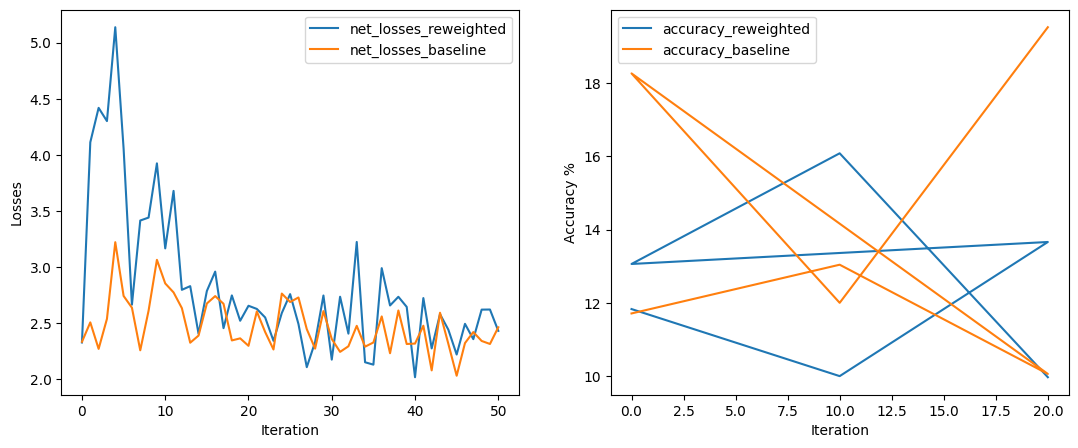

 70%|███████   | 21/30 [02:45<02:13, 14.82s/it]

| Wide-Resnet 28x10
torch.Size([25])
torch.Size([25])


 73%|███████▎  | 22/30 [02:47<01:27, 10.96s/it]

| Wide-Resnet 28x10
torch.Size([25])
torch.Size([25])


 77%|███████▋  | 23/30 [02:49<00:57,  8.24s/it]

| Wide-Resnet 28x10
torch.Size([25])
torch.Size([25])


 80%|████████  | 24/30 [02:51<00:38,  6.46s/it]

| Wide-Resnet 28x10
torch.Size([25])
torch.Size([25])


 83%|████████▎ | 25/30 [02:53<00:25,  5.19s/it]

| Wide-Resnet 28x10
torch.Size([25])
torch.Size([25])


 87%|████████▋ | 26/30 [02:56<00:17,  4.32s/it]

| Wide-Resnet 28x10
torch.Size([25])
torch.Size([25])


 90%|█████████ | 27/30 [02:58<00:10,  3.60s/it]

| Wide-Resnet 28x10
torch.Size([25])
torch.Size([25])


 93%|█████████▎| 28/30 [03:00<00:06,  3.09s/it]

| Wide-Resnet 28x10
torch.Size([25])
torch.Size([25])


 97%|█████████▋| 29/30 [03:01<00:02,  2.74s/it]

| Wide-Resnet 28x10
torch.Size([25])
torch.Size([25])


100%|██████████| 30/30 [03:03<00:00,  6.13s/it]


In [ ]:
_ , acc_log, acc_log_baseline, net_losses, net_losses_baseline = train_lre_cifar()
with open('acc_log_cifar_unif_flip.csv','a') as csvfile:
  np.savetxt(csvfile, acc_log, delimiter=',',fmt='%s', comments='')
  csvfile.close()
with open('acc_log_baseline_cifar_unif_flip.csv','a') as csvfile:
  np.savetxt(csvfile, acc_log_baseline, delimiter=',',fmt='%s', comments='')
  csvfile.close()
with open('loss_log_cifar_unif_flip.csv','a') as csvfile:
  np.savetxt(csvfile, net_losses, delimiter=',',fmt='%s', comments='')
  csvfile.close()
with open('loss_log_baseline_cifar_unif_flip.csv','a') as csvfile:
  np.savetxt(csvfile, net_losses_baseline, delimiter=',',fmt='%s', comments='')
  csvfile.close()